# Introduction

This notebook will illustrate experiments with the Adam optimizer in TensorFlow to solve the `lagaris_04` coupled ODE IVP.

## The `lagaris04` ODE problem

This system of coupled ODEs was used as the fourth example problem in (Lagaris et al., 1998). The differential equations are provided in the form (equations (30), (31) in Lagaris (1998)):

\begin{equation}
    \frac {d\psi_1} {dx} = \cos(x) + \psi_1^2 + \psi_2 - \left(1 + x^2 + \sin^2(x) \right) \\
    \frac {d\psi_2} {dx} = 2 x - \left( 1 + x^2 \right) \sin(x) + \psi_1 \psi_2
\end{equation}

or:

\begin{equation}
    G_1 \left( x, \psi_1, \psi_2, \frac {d\psi_1} {dx}, \frac {d\psi_2} {dx} \right) = \frac {d\psi_1} {dx} - \cos(x) - \psi_1^2 - \psi_2 + \left(1 + x^2 + \sin^2(x) \right) = 0 \\
    G_2 \left( x, \psi_1, \psi_2, \frac {d\psi_1} {dx}, \frac {d\psi_2} {dx} \right) = \frac {d\psi_2} {dx} - 2 x + \left( 1 + x^2 \right) \sin(x) - \psi_1 \psi_2 = 0
\end{equation}

with initial conditions:

\begin{equation}
    \psi_1(0) = 0 \\
    \psi_2(0) = 1
\end{equation}

The analytical solutions are:

\begin{equation}
    \psi_{1a}(x) = \sin (x) \\
    \psi_{2a}(x) = 1 + x^2
\end{equation}

The first derivatives are:

\begin{equation}
    \frac {d\psi_{1a}(x)} {dx} = \cos (x) \\
    \frac {d\psi_{2a}(x)} {dx} = 2 x
\end{equation}

The analytical solutions and derivatives in the domain $[0,1]$ are plotted below.

In [1]:
# Import standard Python modules.
import datetime
import importlib
from math import exp
import os
import platform
import sys

# Import 3rd-party modules.
import matplotlib.pyplot as plt
import numpy as np

# Import TensorFlow.
import tensorflow as tf

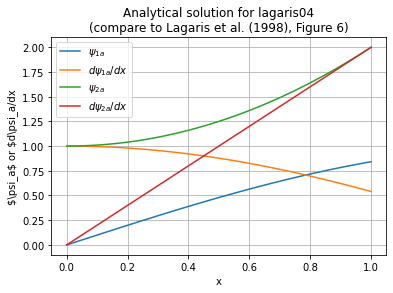

In [2]:
# Import the problem definition.
eq_name = "lagaris04"
eq_module = 'nnde.differentialequation.examples.lagaris_04'
eq = importlib.import_module(eq_module)

# Compute the analytical solution and derivatives.
# Note that Y is used in place of \psi in the code.
na = 101
xa = np.linspace(0, 1, na)
Y1a = [eq.Y1a(x) for x in xa]
Y1a = np.array(Y1a)
Y2a = [eq.Y2a(x) for x in xa]
Y2a = np.array(Y2a)
dY1a_dx = [eq.dY1a_dx(x) for x in xa]
dY1a_dx = np.array(dY1a_dx)
dY2a_dx = [eq.dY2a_dx(x) for x in xa]
dY2a_dx = np.array(dY2a_dx)

# Plot the analytical solution and derivative.
plt.plot(xa, Y1a, label="$\psi_{1a}$")
plt.plot(xa, dY1a_dx, label="$d\psi_{1a}/dx$")
plt.plot(xa, Y2a, label="$\psi_{2a}$")
plt.plot(xa, dY2a_dx, label="$d\psi_{2a}/dx$")
plt.xlabel("x")
plt.ylabel("$\psi_a$ or $d\psi_a/dx")
plt.grid()
plt.legend()
plt.title("Analytical solution for %s\n(compare to Lagaris et al. (1998), Figure 6)" %
         (eq_name));

## Solving `lagaris04` using TensorFlow

In [3]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [4]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [5]:
from nnde.math.trainingdata import create_training_grid

def create_training_data(nt):
    x_train = np.array(create_training_grid(nt))
    return x_train

In [6]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])
    return model

In [7]:
print_system_information()

System report:
2021-09-28 19:33:47.129345
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Mon Aug 30 06:12:21 PDT 2021; root:xnu-7195.141.6~3/RELEASE_X86_64', machine='x86_64')
Python version: 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
Python build: ('default', 'Sep 16 2021 08:50:36')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [8]:
# Buid and train the model.

# Set up the output directory.
path = "./lagaris_04_tf_adam"
output_dir = create_output_directory(path)

# Training optimizer
training_algorithm = "Adam"

# Initial parameter ranges
w0_range = [-1, 1]
u0_range = [-1, 1]
v0_range = [-1, 1]

# Number of hidden nodes.
H = 10

# Number of training points.
nt = 10

# Number of validation points.
nv = 101

# Number of training epochs.
n_epochs = 1000

# Learning rate.
learning_rate = 0.01

# Random number generator seed.
random_seed = 0

# Create and save the training data, then convert to Variable.
xt = create_training_data(nt)
np.savetxt(os.path.join(output_dir,'xt.dat'), xt)
xtv = tf.Variable(xt.reshape((nt, 1)), dtype=tf.float32)

# Build the model.
model1 = build_model(H, w0_range, u0_range, v0_range)
model2 = build_model(H, w0_range, u0_range, v0_range)

# Create history variables.
losses1 = []
losses2 = []
losses = []
phist1 = []
phist2 = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

# Create the optimizers.
optimizer1 = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer2 = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Train the model.

# Rename the training data Variable for convenience, just for training.
x = xtv

print("Hyperparameters: nt = %s, H = %s, n_epochs = %s, learning_rate = %s"
      % (nt, H, n_epochs, learning_rate))
t_start = datetime.datetime.now()
print("Training started at", t_start)

for epoch in range(n_epochs):
#     print("Starting epoch %s." % epoch)

    # Run the forward pass.
    with tf.GradientTape(persistent=True) as tape2:
        with tf.GradientTape(persistent=True) as tape1:

            # Compute the network outputs.
            N1 = model1(x)
            N2 = model2(x)

            # Compute the trial solutions.
            Y1 = x*N1
            Y2 = 1 + x*N2

        # Compute the gradients of trial solutions wrt inputs.
        dY1_dx = tape1.gradient(Y1, x)
        dY2_dx = tape1.gradient(Y2, x)

        # Compute the estimates of the differential equations.
        G1 = dY1_dx - tf.math.cos(x) - Y1**2 - Y2 + 1 + x**2 + tf.math.sin(x)**2
        G2 = dY2_dx - 2*x + (1 + x**2)*tf.math.sin(x) - Y1*Y2

        # Compute the loss functions.
        L1 = tf.math.sqrt(tf.reduce_sum(G1**2)/nt)
        L2 = tf.math.sqrt(tf.reduce_sum(G2**2)/nt)
        L = L1 + L2
    
    # Save the current losses.
    losses1.append(L1.numpy())
    losses2.append(L2.numpy())
    losses.append(L.numpy())

    # Compute the gradients of the loss function wrt the network parameters.
    pgrad1 = tape2.gradient(L, model1.trainable_variables)
    pgrad2 = tape2.gradient(L, model2.trainable_variables)

    # Save the parameters used in this pass.
    phist1.append(
        np.hstack(
            (model1.trainable_variables[0][0].numpy(),    # w (1, H) matrix
             model1.trainable_variables[1].numpy(),       # u (H,) row vector
             model1.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    phist2.append(
        np.hstack(
            (model2.trainable_variables[0][0].numpy(),    # w (1, H) matrix
             model2.trainable_variables[1].numpy(),       # u (H,) row vector
             model2.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    # Update the parameters for this pass.
    optimizer1.apply_gradients(zip(pgrad1, model1.trainable_variables))
    optimizer2.apply_gradients(zip(pgrad2, model2.trainable_variables))

#     print("Ending epoch %s." % epoch)

t_stop = datetime.datetime.now()
print("Training stopped at", t_stop)
t_elapsed = t_stop - t_start
print("Total training time was %s seconds." % t_elapsed.total_seconds())

# Save the parameter histories.
np.savetxt(os.path.join(output_dir, 'phist1.dat'), np.array(phist1))
np.savetxt(os.path.join(output_dir, 'phist2.dat'), np.array(phist2))

# Compute and save the trained results at training points (Ytt).
with tf.GradientTape(persistent=True) as tape1:
    N1 = model1(xtv)
    N2 = model2(xtv)
    Y1tt = xtv*N1
    Y2tt = 1 + xtv*N2
dY1tt_dx = tape1.gradient(Y1tt, xtv)
dY2tt_dx = tape1.gradient(Y2tt, xtv)
np.savetxt(os.path.join(output_dir, 'Y1tt.dat'), Y1tt.numpy().reshape((nt)))
np.savetxt(os.path.join(output_dir, 'Y2tt.dat'), Y2tt.numpy().reshape((nt)))
np.savetxt(os.path.join(output_dir, 'dY1tt_dx.dat'), dY1tt_dx.numpy().reshape((nt)))
np.savetxt(os.path.join(output_dir, 'dY2tt_dx.dat'), dY2tt_dx.numpy().reshape((nt)))

# Compute and save the analytical solution and derivative at training points (Yat).
Y1at = np.array([eq.Y1a(x) for x in xt])
np.savetxt(os.path.join(output_dir,'Y1at.dat'), Y1at)
dY1at_dx = np.array([eq.dY1a_dx(x) for x in xt])
np.savetxt(os.path.join(output_dir,'dY1at_dx.dat'), dY1at_dx)
Y2at = np.array([eq.Y2a(x) for x in xt])
np.savetxt(os.path.join(output_dir,'Y2at.dat'), Y2at)
dY2at_dx = np.array([eq.dY2a_dx(x) for x in xt])
np.savetxt(os.path.join(output_dir,'dY2at_dx.dat'), dY2at_dx)

# Compute and save the error in the trained solution and derivative at training points (Ytt_err).
Y1tt_err = Y1tt.numpy().reshape((nt)) - Y1at
np.savetxt(os.path.join(output_dir, 'Y1tt_err.dat'), Y1tt_err)
dY1tt_dx_err = dY1tt_dx.numpy().reshape((nt)) - dY1at_dx
np.savetxt(os.path.join(output_dir, 'dY1tt_dx_err.dat'), dY1tt_dx_err)
Y2tt_err = Y2tt.numpy().reshape((nt)) - Y2at
np.savetxt(os.path.join(output_dir, 'Y2tt_err.dat'), Y2tt_err)
dY2tt_dx_err = dY2tt_dx.numpy().reshape((nt)) - dY2at_dx
np.savetxt(os.path.join(output_dir, 'dY2tt_dx_err.dat'), dY2tt_dx_err)

# Compute the validation points (xv).
# xv = create_training_data(nv)*3 - 1
xv = create_training_data(nv)
np.savetxt(os.path.join(output_dir,'xv.dat'), xv)
xvv = tf.Variable(xv.reshape((nv, 1)), dtype=tf.float32)

# Compute and save the trained results at validation points (Ytt).
with tf.GradientTape(persistent=True) as tape1:
    N1 = model1(xvv)
    N2 = model2(xvv)
    Y1tv = xvv*N1
    Y2tv = 1 + xvv*N2
dY1tv_dx = tape1.gradient(Y1tv, xvv)
dY2tv_dx = tape1.gradient(Y2tv, xvv)
np.savetxt(os.path.join(output_dir, 'Y1tv.dat'), Y1tv.numpy().reshape((nv)))
np.savetxt(os.path.join(output_dir, 'Y2tv.dat'), Y2tv.numpy().reshape((nv)))
np.savetxt(os.path.join(output_dir, 'dY1tv_dx.dat'), dY1tv_dx.numpy().reshape((nv)))
np.savetxt(os.path.join(output_dir, 'dY2tv_dx.dat'), dY2tv_dx.numpy().reshape((nv)))

# Compute and save the analytical solution and derivative at validation points (Yat).
Y1av = np.array([eq.Y1a(x) for x in xv])
np.savetxt(os.path.join(output_dir,'Y1av.dat'), Y1av)
dY1av_dx = np.array([eq.dY1a_dx(x) for x in xv])
np.savetxt(os.path.join(output_dir,'dY1av_dx.dat'), dY1av_dx)
Y2av = np.array([eq.Y2a(x) for x in xv])
np.savetxt(os.path.join(output_dir,'Y2av.dat'), Y2av)
dY2av_dx = np.array([eq.dY2a_dx(x) for x in xv])
np.savetxt(os.path.join(output_dir,'dY2av_dx.dat'), dY2av_dx)

# Compute and save the error in the trained solution and derivative at validation points (Ytt_err).
Y1tv_err = Y1tv.numpy().reshape((nv)) - Y1av
np.savetxt(os.path.join(output_dir, 'Y1tv_err.dat'), Y1tv_err)
dY1tv_dx_err = dY1tv_dx.numpy().reshape((nv)) - dY1av_dx
np.savetxt(os.path.join(output_dir, 'dY1tv_dx_err.dat'), dY1tv_dx_err)
Y2tv_err = Y2tv.numpy().reshape((nv)) - Y2av
np.savetxt(os.path.join(output_dir, 'Y2tv_err.dat'), Y2tv_err)
dY2tv_dx_err = dY2tv_dx.numpy().reshape((nv)) - dY2av_dx
np.savetxt(os.path.join(output_dir, 'dY2tv_dx_err.dat'), dY2tv_dx_err)

2021-09-28 19:33:47.191780: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Hyperparameters: nt = 10, H = 10, n_epochs = 1000, learning_rate = 0.01
Training started at 2021-09-28 19:33:47.461101
Training stopped at 2021-09-28 19:33:58.347719
Total training time was 10.886618 seconds.


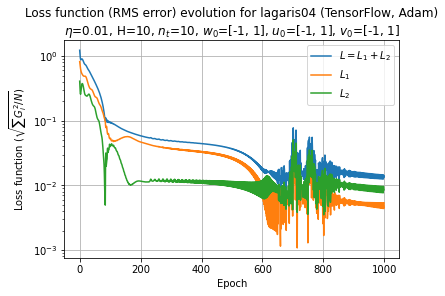

In [9]:
# Plot the loss function history.
plt.semilogy(losses, label="$L=L_1+L_2$")
plt.semilogy(losses1, label="$L_1$")
plt.semilogy(losses2, label="$L_2$")
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/N}$)")
plt.grid()
plt.legend()
plt.title("Loss function (RMS error) evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
plt.show()

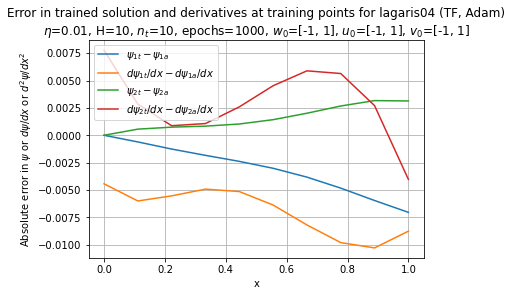

In [10]:
# Plot the errors in the trained solution and derivative at the training points.
plt.plot(xt, Y1tt_err, label="$\psi_{1t} - \psi_{1a}$")
plt.plot(xt, dY1tt_dx_err, label="$d\psi_{1t}/dx - d\psi_{1a}/dx$")
plt.plot(xt, Y2tt_err, label="$\psi_{2t} - \psi_{2a}$")
plt.plot(xt, dY2tt_dx_err, label="$d\psi_{2t}/dx - d\psi_{2a}/dx$")
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi$ or $d\psi/dx$ or $d^2\psi/dx^2$")
plt.grid()
plt.legend()
plt.title("Error in trained solution and derivatives at training points for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, epochs=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TF', training_algorithm, learning_rate, H, nt, n_epochs, w0_range, u0_range, v0_range))
plt.show()

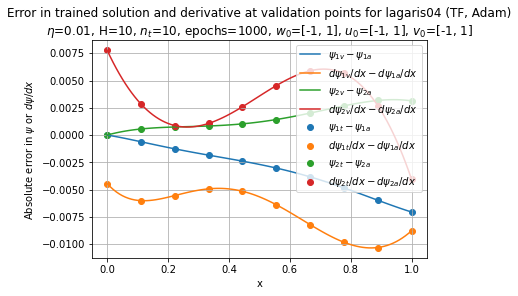

In [11]:
# Plot the errors in the trained solution and derivative at the validation points.
plt.plot(xv, Y1tv_err, label="$\psi_{1v} - \psi_{1a}$")
plt.plot(xv, dY1tv_dx_err, label="$d\psi_{1v}/dx - d\psi_{1a}/dx$")
plt.plot(xv, Y2tv_err, label="$\psi_{2v} - \psi_{2a}$")
plt.plot(xv, dY2tv_dx_err, label="$d\psi_{2v}/dx - d\psi_{2a}/dx$")
plt.scatter(xt, Y1tt_err, label="$\psi_{1t} - \psi_{1a}$", marker='o')
plt.scatter(xt, dY1tt_dx_err, label="$d\psi_{1t}/dx - d\psi_{1a}/dx$", marker='o')
plt.scatter(xt, Y2tt_err, label="$\psi_{2t} - \psi_{2a}$", marker='o')
plt.scatter(xt, dY2tt_dx_err, label="$d\psi_{2t}/dx - d\psi_{2a}/dx$", marker='o')
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi$ or $d\psi/dx$")
plt.grid()
plt.legend()
plt.title("Error in trained solution and derivative at validation points for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, epochs=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TF', training_algorithm, learning_rate, H, nt, n_epochs, w0_range, u0_range, v0_range))
plt.show()

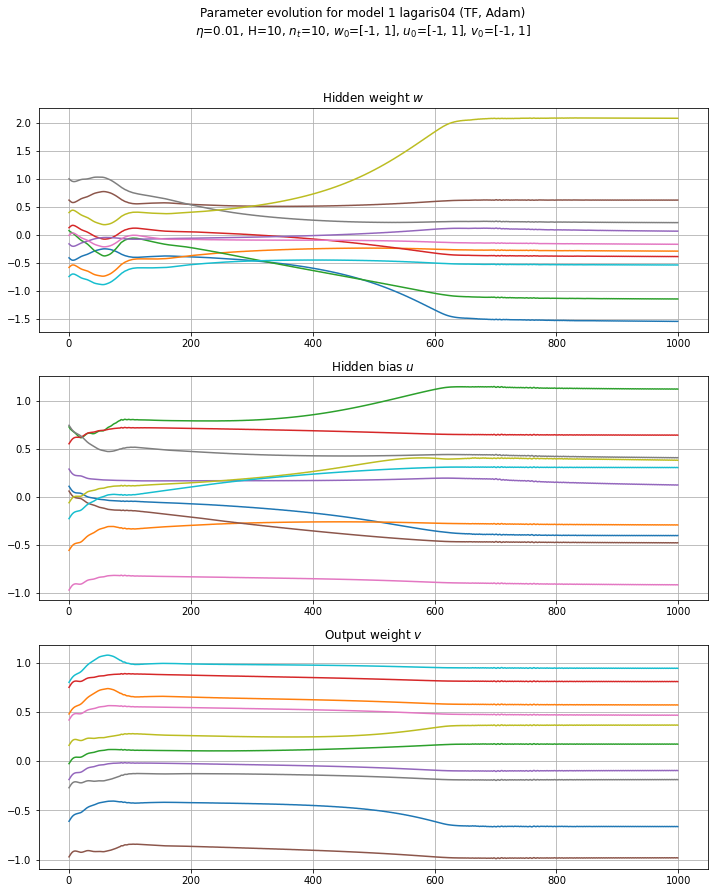

In [12]:
# Plot the parameter histories for model 1.
phist = np.array(phist1)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for model 1 %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TF', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
plt.subplots_adjust(hspace=0.2)
plt.show()

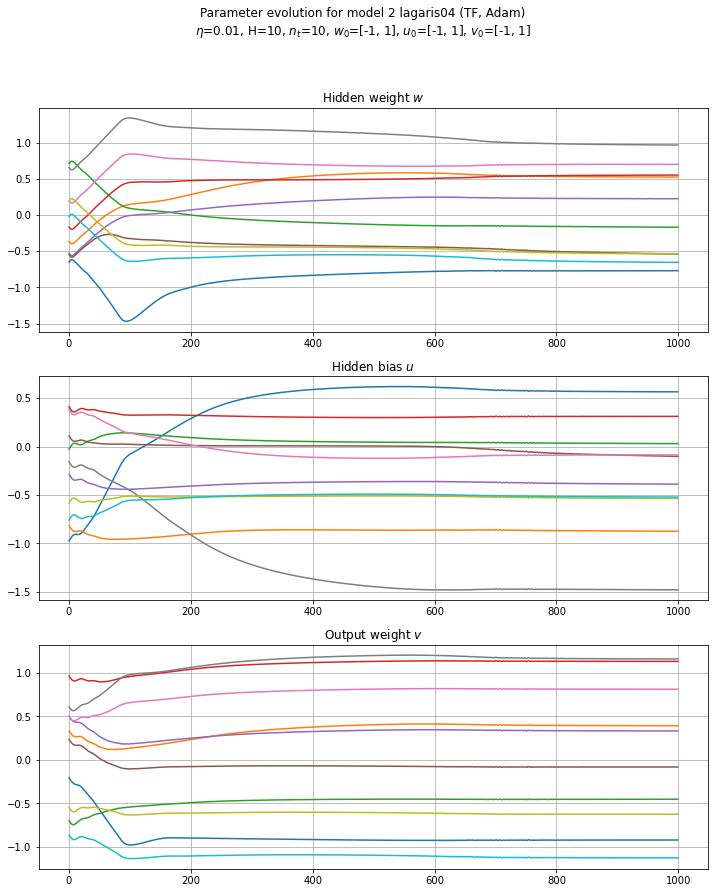

In [13]:
# Plot the parameter histories for model 2.
phist = np.array(phist2)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for model 2 %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TF', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
plt.subplots_adjust(hspace=0.2)
plt.show()